In [1]:
# Import required libraries
import pandas as pd
import os
import numpy as np
import seaborn as sns

In [2]:
df_list = []

for file in os.listdir('./data'):
    df_list.append(pd.read_csv(f"./data/{file}"))

resale_df = pd.concat(df_list)

In [3]:
# since remaining lease only exists in a few of the datasets, it will be removed and recalculated in a following step
resale_df = resale_df.drop(columns=['remaining_lease'])

In [4]:
resale_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 826581 entries, 0 to 80373
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                826581 non-null  object 
 1   town                 826581 non-null  object 
 2   flat_type            826581 non-null  object 
 3   block                826581 non-null  object 
 4   street_name          826581 non-null  object 
 5   storey_range         826581 non-null  object 
 6   floor_area_sqm       826581 non-null  float64
 7   flat_model           826581 non-null  object 
 8   lease_commence_date  826581 non-null  int64  
 9   resale_price         826581 non-null  float64
dtypes: float64(2), int64(1), object(7)
memory usage: 69.4+ MB


In [5]:
# splitting the month and the year allows to check long term trend as well as seasonality in the year itself.
resale_df[['year', 'month_2']] = resale_df['month'].str.split('-').to_list()
resale_df['year'] = resale_df['year'].astype(int)
resale_df['month_2'] = resale_df['month_2'].astype(int)

resale_df['month_index'] = resale_df['year'].astype(int)*12 + resale_df['month_2'].astype(int)
resale_df['lease_commence_index'] = resale_df['lease_commence_date']*12

# recalculate remaining_lease in years, rounding down to the closest year
resale_df['remaining_lease'] = np.floor((99 * 12 - (resale_df['month_index'] - resale_df['lease_commence_index']))/12)

Correlating the resale price with the different time-based parameters shows that there's a relatively high positive correlation between the year of purchase as well as the lease commence date. Year and remaining lease are also negatively correlated as the, implying that properties bought later tend to on average be older.

In [6]:
resale_df[['resale_price', 'year', 'month_2', 'lease_commence_date', 'remaining_lease']].corr()

,resale_price,year,month_2,lease_commence_date,remaining_lease
resale_price,1.000000,0.604590,0.015991,0.499849,-0.006906
year,0.604590,1.000000,-0.017939,0.373302,-0.448334
month_2,0.015991,-0.017939,1.000000,0.009740,0.023879
lease_commence_date,0.499849,0.373302,0.009740,1.000000,0.661884
remaining_lease,-0.006906,-0.448334,0.023879,0.661884,1.000000


Plotting the year, against the resale price shows a clear increase in resale prices. However, the resale price has been relatively flat for the last few years.

<Axes: xlabel='year', ylabel='resale_price'>

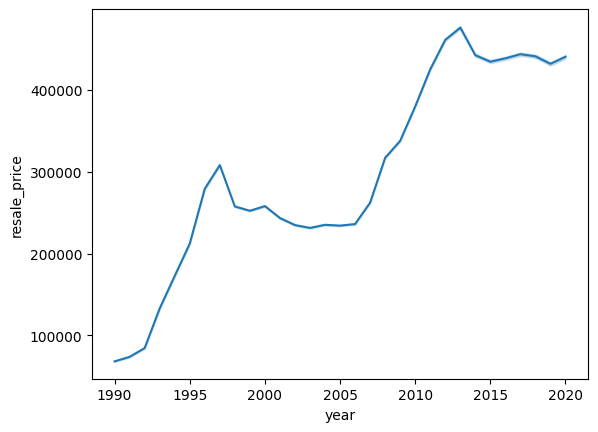

In [7]:
sns.lineplot(resale_df, x='year', y='resale_price')

For the rest of this analysis, only the last 5 years will be considered to better understand recent trends, without muddying it up with older trends.

In [8]:
analysis_df = resale_df.query("year >= 2016")

Lease commence date and remaining lease aside, there does not seem to be much correlation between resale price and any other parameter.

In [9]:
analysis_df[['resale_price', 'year', 'month_2', 'lease_commence_date', 'remaining_lease']].corr()

,resale_price,year,month_2,lease_commence_date,remaining_lease
resale_price,1.000000,-0.009236,0.000980,0.331244,0.334608
year,-0.009236,1.000000,-0.082367,0.119199,0.011107
month_2,0.000980,-0.082367,1.000000,0.012281,0.021341
lease_commence_date,0.331244,0.119199,0.012281,1.000000,0.994133
remaining_lease,0.334608,0.011107,0.021341,0.994133,1.000000


Plotting the month against the resale price does not show either trend or any other relationship.

<Axes: xlabel='month_2', ylabel='resale_price'>

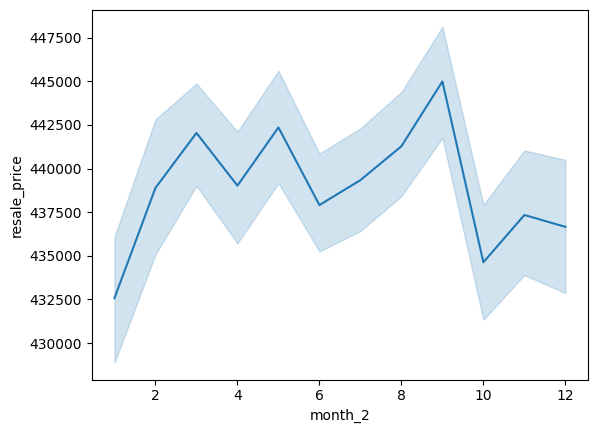

In [10]:
sns.lineplot(analysis_df, x='month_2', y='resale_price')

Comparing the remaining lease to the resale prices shows that resale prices tend to decline as the property have fewer years left.

<Axes: xlabel='remaining_lease', ylabel='resale_price'>

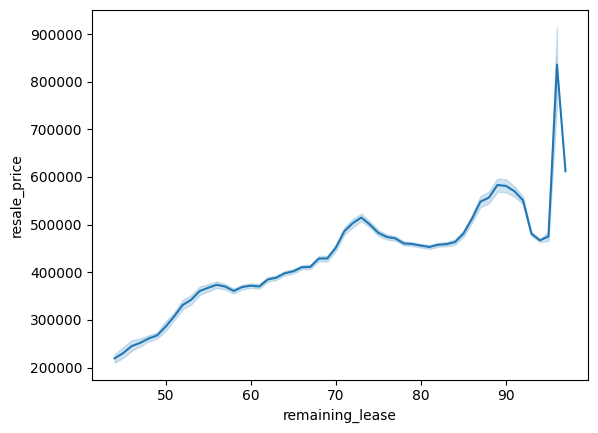

In [11]:
sns.lineplot(analysis_df, x='remaining_lease', y='resale_price')

The following list shows the average resale prcies for each town in the latest 5 years. The town where the property is has a strong influence on the resale price.

In [12]:
analysis_df.groupby('town').agg({'resale_price': 'mean', 'town':'count'}).sort_values('resale_price', ascending=False)

,resale_price,town
town,,
BUKIT TIMAH,709084.094891,274
BISHAN,637188.574646,1909
CENTRAL AREA,621068.028235,850
BUKIT MERAH,559644.984520,3819
QUEENSTOWN,556494.880443,2620
MARINE PARADE,513579.634483,580
KALLANG/WHAMPOA,497199.295772,2914
PASIR RIS,489660.666333,2994
SERANGOON,487672.007386,2031


The high cardinality of the street name makes it hard to easily analyse and could make it hard to train any model trained on it, however, the street does capture useful information related to a more granular location. To reduce cardinality while adding more granular information, the average street price and the frequency of the transactions on that street will be considered.

There's a very high positive correlation between the mean street price and the actual resale price.

<Axes: xlabel='mean_street_price', ylabel='resale_price'>

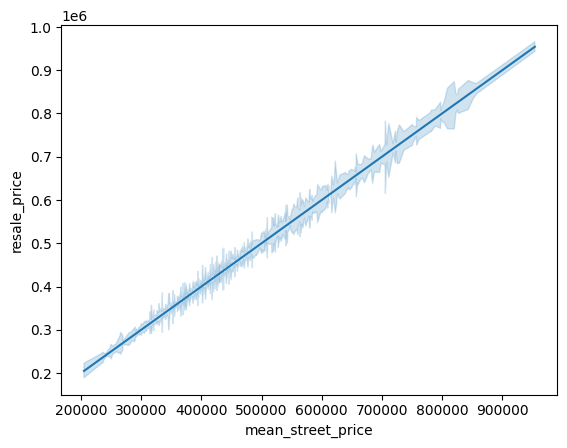

In [13]:

street_df = analysis_df.groupby('street_name')['resale_price'].mean().reset_index().rename(columns={'resale_price':'mean_street_price'})
analysis_df = analysis_df.merge(street_df, on='street_name')
sns.lineplot(analysis_df, x='mean_street_price', y='resale_price')
# analysis_df[['mean_street_price', 'resale_price']].corr()

In [14]:
street_df = pd.DataFrame(analysis_df.value_counts('street_name')).reset_index()
street_df['street_frequency'] = pd.qcut(street_df['count'], q=5, labels=False)
street_df
analysis_df = analysis_df.merge(street_df[['street_name', 'street_frequency']], on='street_name')


A lower frequency of sales on that street seems to have a very slight negative correlation with the resale price.

<Axes: xlabel='street_frequency', ylabel='resale_price'>

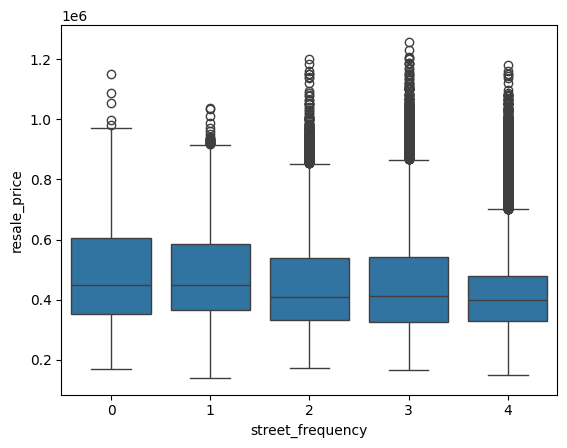

In [15]:
sns.boxplot(analysis_df, x='street_frequency', y='resale_price')

The flat type also has a strong influence on the resale price.

<Axes: xlabel='flat_type', ylabel='resale_price'>

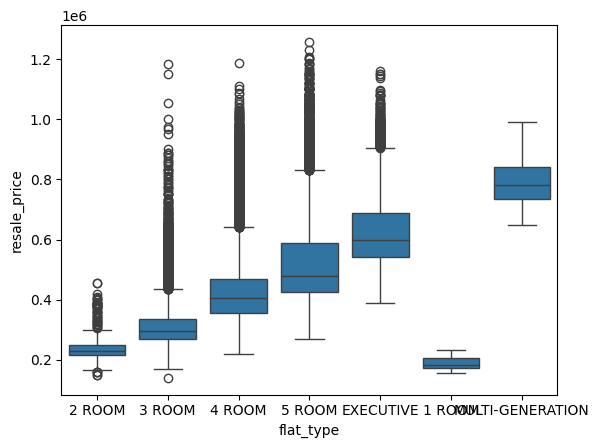

In [16]:
sns.boxplot(analysis_df, x='flat_type', y='resale_price')

While there is a very strong correlation between the floor the unit is on and the resale price, there is a long tail for the higher floors. Higher floors have therefore been grouped together to reduce the noise due to small counts.

In [17]:
analysis_df['storey_range'] = analysis_df.storey_range.replace(['19 TO 21', '22 TO 24', '25 TO 27', '28 TO 30', '31 TO 33','34 TO 36','37 TO 39','40 TO 42','43 TO 45','46 TO 48','49 TO 51'], '19+')
analysis_df.groupby('storey_range').agg({'resale_price':'mean', 'storey_range':'count'})

,resale_price,storey_range
storey_range,,
01 TO 03,396051.820367,18027
04 TO 06,413057.008284,23376
07 TO 09,425202.084745,21295
10 TO 12,438508.834079,18789
13 TO 15,474377.726472,9233
16 TO 18,517253.185033,4129
19+,654658.134831,4898


There is also a very positive correlation between the size of the property and the resale price.

<Axes: xlabel='floor_area_sqm', ylabel='resale_price'>

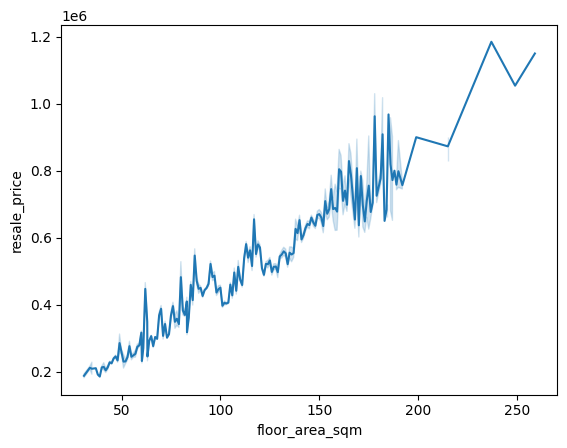

In [18]:
sns.lineplot(analysis_df, x='floor_area_sqm', y='resale_price')

There are a lot of different flat model types and a lot of them do not have that many transactions, making any correlation between the flat type and the resale price hard. However, there are a few flat types, like the 'Improved' and 'Model A' that could potentially help in predicting future prices. To reduce cardinality, any category that has fewer than 500 transactions will be grouped together in a catch-all 'OTHER' class.

In [19]:
analysis_df['flat_model'] = analysis_df.flat_model.replace(
analysis_df.groupby('flat_model').agg({'resale_price':'mean', 'flat_model':'count'}).rename(columns={'flat_model':'count'}).reset_index().query("count < 500")['flat_model'].to_list(),
'OTHERS'
)

analysis_df.groupby('flat_model').agg({'resale_price':'mean', 'flat_model':'count'}).rename(columns={'flat_model':'count'})

,resale_price,count
flat_model,,
Apartment,608716.714464,4010
DBSS,760277.089214,1502
Improved,450934.265455,24929
Maisonette,671652.306030,2907
Model A,423816.546907,32213
Model A2,347466.591518,1344
New Generation,334623.987033,14276
OTHERS,802905.012475,792
Premium Apartment,461292.910814,10629


To better determine the relative importance of each variable and predict the resale price of new transactions, categorical values will be one hot encoded and irrelevant columns will be removed.

In [20]:
analysis_df = analysis_df.drop(columns=['month', 'block', 'street_name', 'month_index','lease_commence_index'])

To reduce the number of columns that are generated before one-hot encoding the storey range will be ordinally encoded as a higher number in the context of floors will still hold meaning, even after ordinal encoding.

In [21]:
analysis_df.storey_range.unique()

array(['07 TO 09', '01 TO 03', '04 TO 06', '10 TO 12', '16 TO 18', '19+',
       '13 TO 15'], dtype=object)

In [22]:
analysis_df['storey_range'] = analysis_df.storey_range.map({
    '01 TO 03':0,
    '04 TO 06':1,
    '07 TO 09':2,
    '10 TO 12':3,
    '13 TO 15':4,
    '16 TO 18':5,
    '19+':6
})

analysis_df = pd.get_dummies(analysis_df)

In [23]:
analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99747 entries, 0 to 99746
Data columns (total 53 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   storey_range                  99747 non-null  int64  
 1   floor_area_sqm                99747 non-null  float64
 2   lease_commence_date           99747 non-null  int64  
 3   resale_price                  99747 non-null  float64
 4   year                          99747 non-null  int64  
 5   month_2                       99747 non-null  int64  
 6   remaining_lease               99747 non-null  float64
 7   mean_street_price             99747 non-null  float64
 8   street_frequency              99747 non-null  int64  
 9   town_ANG MO KIO               99747 non-null  bool   
 10  town_BEDOK                    99747 non-null  bool   
 11  town_BISHAN                   99747 non-null  bool   
 12  town_BUKIT BATOK              99747 non-null  bool   
 13  t

The next section will train a simple XGBoost model, as it's able to produce good prediction results as well as being explainable. Further, as there's a constraint on the available resources, i.e. some colleagues only having CPUs, XGBoost still works fast on CPUs as well as GPUs. To keep the latest trend, only the latest 5 years will be used.

In [24]:
from xgboost import XGBRegressor
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [25]:
# split dataset into train, test and validate sets

x_train, x_test, y_train, y_test = train_test_split(analysis_df.drop(columns=['resale_price']), analysis_df['resale_price'], test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

In [26]:
model = XGBRegressor(eval_metric='rmse', early_stopping_rounds=5, n_estimators=2000)
model.fit(x_train, y_train, eval_set=[(x_val, y_val)])

[0]	validation_0-rmse:115022.70630
[1]	validation_0-rmse:91260.32211
[2]	validation_0-rmse:75741.75521
[3]	validation_0-rmse:65659.88848
[4]	validation_0-rmse:59012.22789
[5]	validation_0-rmse:54534.86624
[6]	validation_0-rmse:51436.51347
[7]	validation_0-rmse:49156.38383
[8]	validation_0-rmse:47292.08949
[9]	validation_0-rmse:46028.04848
[10]	validation_0-rmse:45180.40932
[11]	validation_0-rmse:44315.58052
[12]	validation_0-rmse:43539.04068
[13]	validation_0-rmse:42584.19831
[14]	validation_0-rmse:41585.93952
[15]	validation_0-rmse:40903.77934
[16]	validation_0-rmse:40544.36403
[17]	validation_0-rmse:40143.30290
[18]	validation_0-rmse:39552.08758
[19]	validation_0-rmse:39161.53283
[20]	validation_0-rmse:38850.57768
[21]	validation_0-rmse:38348.97980
[22]	validation_0-rmse:37962.55803
[23]	validation_0-rmse:37453.79091
[24]	validation_0-rmse:37056.79260
[25]	validation_0-rmse:36759.16727
[26]	validation_0-rmse:36376.02633
[27]	validation_0-rmse:36073.89270
[28]	validation_0-rmse:35590.

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,5
,enable_categorical,False
,eval_metric,'rmse'


From the training, it seems that the room type, especially the 2 room type influences the price the most, followed closely by mean_street_price and floor area. While each individual town does not have a large gain, the towns as a collective are very impactful.

<Axes: >

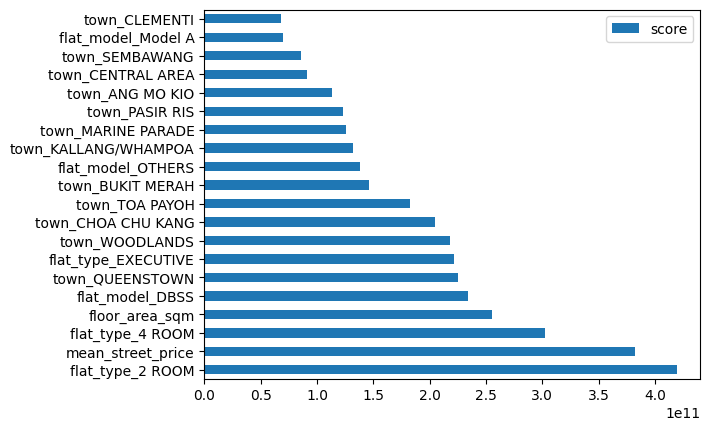

In [27]:
feature_importance = model.get_booster().get_score(importance_type='gain')
keys = list(feature_importance.keys())
values = list(feature_importance.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(20, columns='score').plot(kind='barh')